<a href="https://colab.research.google.com/github/skj092/Object-Detection-with-Oxford-IIIT-Pet-Dataset/blob/main/iiit_object_detection_pets_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET

class CustomObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.xml_files = [file for file in os.listdir(os.path.join(root_dir, 'annotations/xmls')) if file.endswith('.xml')]

    def __len__(self):
        return len(self.xml_files)

    def __getitem__(self, idx):
        xml_file = os.path.join(self.root_dir, 'annotations/xmls', self.xml_files[idx])
        img_name = os.path.splitext(self.xml_files[idx])[0] + '.jpg'
        img_path = os.path.join(self.root_dir, 'images', img_name)

        # Load image
        img = Image.open(img_path).convert("RGB").resize((224,224))

        # Load and parse XML annotation
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Extract image size
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)

        # Initialize lists for target data
        boxes = []
        labels = []

        # Extract bounding box information
        for obj in root.findall('object'):
            label = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)

            # Append bounding box coordinates and label
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # Convert boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor([labels.index(label) for label in labels], dtype=torch.int64)

        # Calculate area (optional)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Define iscrowd (optional)
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # Create target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transform:
            img, target = self.transform(img, target)

        return img, target

if __name__ == "__main__":
    pass


In [ ]:
import torchvision
import torch
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
num_classes = 3

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2,
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
)

if __name__ == "__main__":
    model.eval()
    x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
    predictions = model(x)  # Returns predictions
    print(predictions[0])


In [43]:
from fastai.vision.all import *
from torchvision.transforms import v2 as T
import torch
from torch.utils.data import random_split, DataLoader, Subset
from engine import train_one_epoch


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float))
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

# download the dataset
path = untar_data(URLs.PETS)
Path.BASE_PATH  = path
#print(path.ls())

# dataset and dataloader
ds = CustomObjectDetectionDataset(path, transform=get_transform(train=True))

# Define the dataset size and the desired split ratio
dataset_size = len(ds)
validation_split = 0.2  # 20% of the data will be used for validation

# Calculate the sizes of the training and validation sets
valid_size = int(validation_split * dataset_size)
train_size = dataset_size - valid_size

# Use random_split to split the dataset into train and validation subsets
train_subset, valid_subset = random_split(ds, [train_size, valid_size])

# Create DataLoader objects for train and validation sets
batch_size = 4  # You can adjust this to your preference
train_loader = DataLoader(train_subset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

# Optionally, you can create a complete dataset for train and validation
train_ds = Subset(ds, train_subset.indices)
valid_ds = Subset(ds, valid_subset.indices)

#print(len(train_ds), len(valid_ds))
xb, yb = next(iter(train_loader))
#print(xb[0].shape)
#print(yb)

# testing on one batch
#images, targets = next(iter(train_loader))
#images = list(image for image in images)
#target = [{k: v for k, v in t.items()} for t in targets]
model.to(device)
#output = model(images, target)  # Returns losses and detections
#print(output)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

#evaluate(model, valid_loader, device=device)

for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
  #  evaluate(model, valid_loader, device=device)

# print("That's it!")


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Epoch: [0]  [  0/738]  eta: 0:12:04  lr: 0.000012  loss: 0.1476 (0.1476)  loss_classifier: 0.0031 (0.0031)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.1104 (0.1104)  loss_rpn_box_reg: 0.0341 (0.0341)  time: 0.9820  data: 0.1740  max mem: 5750
Epoch: [0]  [ 50/738]  eta: 0:06:24  lr: 0.000351  loss: 0.1602 (0.5279)  loss_classifier: 0.0028 (0.0035)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.1065 (0.1763)  loss_rpn_box_reg: 0.0480 (0.3481)  time: 0.5405  data: 0.0263  max mem: 5750
Epoch: [0]  [100/738]  eta: 0:05:53  lr: 0.000690  loss: 0.1746 (0.5530)  loss_classifier: 0.0039 (0.0036)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.1218 (0.1723)  loss_rpn_box_reg: 0.0634 (0.3770)  time: 0.5490  data: 0.0282  max mem: 5750
Epoch: [0]  [150/738]  eta: 0:05:25  lr: 0.001028  loss: 0.1741 (0.5648)  loss_classifier: 0.0039 (0.0037)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.1106 (0.1639)  loss_rpn_box_reg: 0.0538 (0.3972)  time: 0.5516  data: 0.0273  max mem: 5750


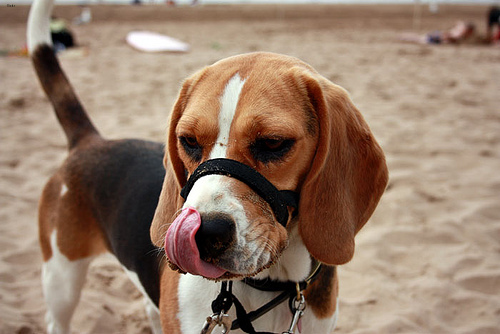

In [46]:
from glob import glob
images = glob('../root/.fastai/data/oxford-iiit-pet/images/*')
Image.open(images[0])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


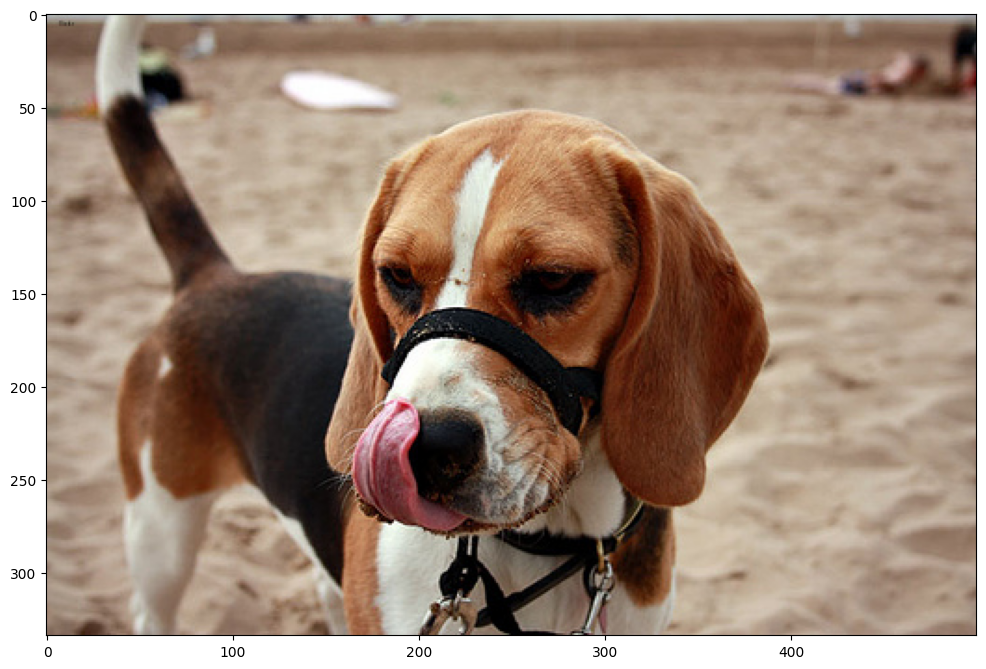

In [50]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.io import read_image


image = read_image(images[0])
eval_transform = get_transform(train=True)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [49]:
predictions

[{'boxes': tensor([], device='cuda:0', size=(0, 4)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0')}]